In [13]:
import sys, os, time, pickle, sklearn
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import qinfer as qi
import importlib as imp

In [14]:
%matplotlib inline

In [15]:
sys.path.append(os.path.abspath(".."))
import qmla

In [16]:
%run revival_data_lib.py

ERROR:root:File `'revival_data_lib.py'` not found.


# Data import

In [11]:
# directory = os.path.abspath("C:/Users/AAG/OneDrive/Work @OneDrive/@Bristol OneDrive/QMLA project/QML_share_stateofart/RawSebData_QML/NV05_HahnEcho01_highres")

directory = os.path.abspath("~Dropbox/QML_share_stateofart/RawSebData_QML/NV05_HahnEcho01_highres")


In [12]:
%%capture
xdata, ydata = obtaindata(directory)

NameError: name 'obtaindata' is not defined

In [19]:
os.path.abspath( "qmla/growth_rules/nv_centre_spin_characterisation/data/NV05_" )

'/home/bf16951/QMD/DevelopmentNotebooks/qmla/growth_rules/nv_centre_spin_characterisation/data'

In [466]:
increment = np.round(np.mean(xdata[1:]-xdata[:-1]), 1)
increment

0.1

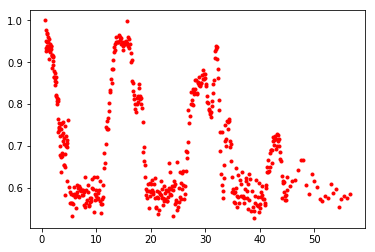

In [106]:
plt.plot(xdata, ydata, "r.", label="Exp. Data")

plt.show()

# Dynamic analysis for Hahn echo experiments

In [2178]:
n_qubits = 2
true_model_terms_params = {
    # spin
#     'pauliSet_1_x_d{}'.format(n_qubits) : 1.94e9,
#     'pauliSet_1_y_d{}'.format(n_qubits) : 1.94e9,
    'pauliSet_1_z_d{}'.format(n_qubits) : 2e9,
    
    'pauliSet_1J2_zJz_d{}'.format(n_qubits) : 0.2e6, 
#     'pauliSet_1J3_zJz_d{}'.format(n_qubits) : 2.4e6, 
#     'pauliSet_1J4_zJz_d{}'.format(n_qubits) : 2.14e6, 
#     'pauliSet_1J5_zJz_d{}'.format(n_qubits) : 2.14e6, 
# #     'pauliSet_1J6_zJz_d{}'.format(n_qubits) : 2.14e6, 

    'pauliSet_1J2_yJy_d{}'.format(n_qubits) : 0.4e6, 
#     'pauliSet_1J3_yJy_d{}'.format(n_qubits) : 2.4e6, 
#     'pauliSet_1J4_yJy_d{}'.format(n_qubits) : 2.14e6, 
#     'pauliSet_1J5_yJy_d{}'.format(n_qubits) : 2.14e6, 
# #     'pauliSet_1J6_yJy_d{}'.format(n_qubits) : 2.14e6, 

    'pauliSet_1J2_xJx_d{}'.format(n_qubits) : 0.2e6, 
#     'pauliSet_1J3_xJx_d{}'.format(n_qubits) : 2.4e6, 
#     'pauliSet_1J4_xJx_d{}'.format(n_qubits) : 2.14e6, 
#     'pauliSet_1J5_xJx_d{}'.format(n_qubits) : 2.14e6, 
# #     'pauliSet_1J6_xJx_d{}'.format(n_qubits) : 2.14e6, 

#     # carbon nuclei - 2nd qubit
    'pauliSet_2_x_d{}'.format(n_qubits) : 66e3,
    'pauliSet_2_y_d{}'.format(n_qubits) : 66e3,
    'pauliSet_2_z_d{}'.format(n_qubits) : 15e3,

#     # carbon nuclei - 3rd qubit
#     'pauliSet_3_x_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_3_y_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_3_z_d{}'.format(n_qubits) : 117e3,

#     # carbon nuclei - 4th qubit
#     'pauliSet_4_x_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_4_y_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_4_z_d{}'.format(n_qubits) : 117e3,

#     # carbon nuclei - 5th qubit
#     'pauliSet_5_x_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_5_y_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_5_z_d{}'.format(n_qubits) : 117e3,

    # carbon nuclei - 6th qubit
#     'pauliSet_6_x_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_6_y_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_6_z_d{}'.format(n_qubits) : 117e3,
    
    # nitrogen nuclei // NEGLECTED
}

In [2179]:
true_model = '+'.join(
    (true_model_terms_params.keys())
)
true_model = qmla.construct_models.alph(true_model)
true_model

'pauliSet_1J2_xJx_d2+pauliSet_1J2_yJy_d2+pauliSet_1J2_zJz_d2+pauliSet_1_z_d2+pauliSet_2_x_d2+pauliSet_2_y_d2+pauliSet_2_z_d2'

In [2180]:
hamiltonian = None
for k in true_model_terms_params:
    
    param = true_model_terms_params[k]
    mtx = qmla.construct_models.compute(k)
    
    if hamiltonian is None: 
        hamiltonian = param * mtx
    else:
        hamiltonian += param * mtx

In [2181]:
num_qubits = int(np.log2(np.shape(hamiltonian))[0])
probe_set = qmla.shared_functionality.probe_set_generation.plus_plus_with_phase_difference(
    num_probes=1, 
    max_num_qubits=num_qubits,
    noise_level=0
)
probe = probe_set[(0,num_qubits)]
probe

[|++'> probes] Noise factor: 0.01


array([ 0.49840374+0.00607048j, -0.18091421+0.46873623j,
        0.49755675-0.00087249j, -0.17405709+0.47037635j])

In [20]:
myham = 2.87e9*np.kron(I2d(), I2d()) + \
        true_model_terms_params['pauliSet_1_z_d2']*np.kron(sigmaz(), I2d()) + \
        true_model_terms_params['pauliSet_1J2_zJz_d2']*np.kron(sigmaz(), sigmaz()) + \
        true_model_terms_params['pauliSet_2_x_d2']*np.kron(I2d(), sigmax()) + \
        true_model_terms_params['pauliSet_2_y_d2']*np.kron(I2d(), sigmay()) + \
        true_model_terms_params['pauliSet_2_z_d2']*np.kron(I2d(), sigmaz())
myham

NameError: name 'I2d' is not defined

In [2183]:
ex_val_list_check = []

for t in times:
    ex_val_list_check.append(1-likelihood_fromevo(myham, t, probe))

In [2184]:
start = time.time()

max_time = 60e-6
time_increment = increment*10**-6
# max_time = 500e-6
# time_increment = 5e-6
times = np.arange(0, max_time, time_increment)

expectation_values = {
    t : qmla.shared_functionality.n_qubit_hahn_evolution(
        ham = hamiltonian, 
        t = t,
        state = probe
    )
    for t in times
}

ex_val_list = [expectation_values[t] for t in times]

In [2185]:
%matplotlib inline

Model: pauliSet_1J2_xJx_d2+pauliSet_1J2_yJy_d2+pauliSet_1J2_zJz_d2+pauliSet_1_z_d2+pauliSet_2_x_d2+pauliSet_2_y_d2+pauliSet_2_z_d2


Text(0.5, 0, 'Time $s$')

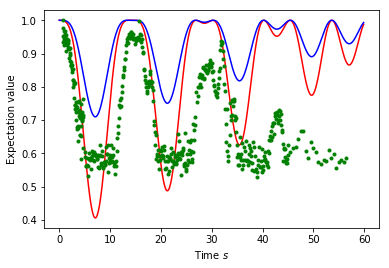

In [2186]:
print("Model:", true_model)
plt.plot(
    times*10**6,
    ex_val_list, 
    color='r',
    ms = 40, 
    markevery=10
)

plt.plot(
    times*10**6,
    ex_val_list_check, 
    color='b'
)

plt.plot(xdata, ydata, "g.", label="Exp. Data")

plt.figsize=(15, 10)
plt.ylabel('Expectation value')
plt.xlabel('Time $s$')